#Normalize Temperatures

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time as t
%matplotlib inline

create a vector with all stations, and for each station_id:


 1. Get min(year), max(year) and min(month) on the 1st year and max(month) on the last year
 2. Divide by month
 3. Calculate normalized temperatures in a new field: Tnorm = T m,s,y - Tavg(m,s)
 3. index by year
 4. reindex by year (from min to max) to generates nas
 5. moving average /smoothing
 


First, we'll define the functions we are going to need:

    relevant_dates
    split by one month
    index by year
    reindex
    apply ewma
    apply moving average

and a function that does all process for a given dataset of a station-month

In [30]:
#calculate min years of the data set and 1st month with data and last month with data for a given station
def relevant_dates(station_data):
    """returns min_year, max_year, min month for 1st year and max month for last year for a given station"""
    min_year, max_year = min(station_data.Year), max(station_data.Year)
    min_month_1styear = min(station_data[station_data.Year == min_year].Month)
    max_month_lastyear = max(station_data[station_data.Year == max_year].Month)
    return   min_year, max_year, min_month_1styear, max_month_lastyear

In [31]:
#split station_data by the given month
def splitbyonemonth(station_data,month):
    "returns data for the given month"
    return station_data[station_data.Month == month]

In [32]:
#make years to be index
def indexbyyear(station_data):
    return station_data.set_index(station_data.Year)

In [33]:
#create empty year rows and fill them with na

    #first year: month >= min_month_1styear else min_year +1
    #last year: month <= max_month_lastyer else max_year -1


def reindex(station_data):
    #calculate relevant dates with previously defined function
    min_year, max_year, min_month_1styear, max_month_lastyear = relevant_dates(test_station_s)
    
    if station_data.Month.min() < min_month_1styear:
        min_year = min_year + 1
    else: 
        True
    if station_data.Month.min() > max_month_lastyear:
        max_year = max_year - 1
    else: 
        pass
    return station_data.reindex(np.arange(min_year,max_year+1))

In [34]:
#exponentially-weighted moving average (EWMA): it computes weighted averages where the most recent value has the highest weight 
# and handles missing values better than rolling_mean (needs all values to calculate the mean or sets na)

ewma_span = 4

def applyewma(station_data):
    return pd.ewma(station_data['Temperature Norm'],span = ewma_span)

In [35]:
min_periods = 1
periods = 5

#calculate moving average with 5 periods, centered and only one value is necessary to compute

def applymovingaverage(station_data):
    return pd.rolling_mean(station_data['Temperature Norm'],periods, center = True, min_periods = min_periods)

In [36]:
def full_process(month_station_data):
    """returns the given station data with the normalized temperatures"""
    meanT = month_station_data['Temperature (C)'].mean()
    month_station_data['Temperature Norm'] = month_station_data['Temperature (C)'] - meanT
    month_station_data_reindexed =  reindex(indexbyyear(month_station_data))
    month_station_data_reindexed['Temperature Norm Smoothed (ewma)']= applyewma(month_station_data_reindexed)
    month_station_data_reindexed['Temperature Norm Smoothed (moving avg)']= applymovingaverage(month_station_data_reindexed)
    return month_station_data_reindexed.dropna()
    

#Execution for our data

A csv is imported and temperatures are normalized. The csv should have: 'Month', 'Year', 'Station ID', 'Temperature (C)' and the columns that are dropped in the following cell

In [37]:
test_station = pd.read_csv('Dades/OUTPUT 01 Filtered Dades Peninsula.csv', skipinitialspace = True)
#remove unnecessary columns
test_station = test_station.drop(['Series Number','Uncertainty (C)', 'Observations', 'Time of Observation' ],1)

In [38]:
#get all station ids
stations = pd.Series(test_station['Station ID']).unique()

#create new empty dataframe to introduce normalized values

station_data_normalized = pd.DataFrame(columns= ['Station ID','Year','Month','Temperature (C)','Date'])
s = 0

#go over all stations with a while and append the normalized values in this new dataframe

while s < len(stations):
    test_station_s = test_station[test_station['Station ID']== stations[s]]
    #full process for each month 
    station_data_1 = full_process(splitbyonemonth(test_station_s,1))
    station_data_2 = full_process(splitbyonemonth(test_station_s,2))
    station_data_3 = full_process(splitbyonemonth(test_station_s,3))
    station_data_4 = full_process(splitbyonemonth(test_station_s,4))
    station_data_5 = full_process(splitbyonemonth(test_station_s,5))
    station_data_6 = full_process(splitbyonemonth(test_station_s,6))
    station_data_7 = full_process(splitbyonemonth(test_station_s,7))
    station_data_8 = full_process(splitbyonemonth(test_station_s,8))
    station_data_9 = full_process(splitbyonemonth(test_station_s,9))
    station_data_10 = full_process(splitbyonemonth(test_station_s,10))
    station_data_11 = full_process(splitbyonemonth(test_station_s,11))
    station_data_12 = full_process(splitbyonemonth(test_station_s,12))
    
    frames = [station_data_normalized, station_data_1, station_data_2, station_data_3, station_data_4, station_data_5, station_data_6, station_data_7, station_data_8, station_data_9, station_data_10, station_data_11, station_data_12]
    
    station_data_normalized = pd.concat(frames, ignore_index=True)
    
    s = s+1


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
#check exit file

if len(test_station) == len(station_data_normalized):
    print 'OK: no rows lost'
else: print 'ERROR', len(test_station) - len(station_data_normalized), 'lost'

OK: no rows lost


In [40]:
#add date type to YYYY-MM-DD format
station_data_normalized['DateISO'] = 0
s = 0
while s < len(station_data_normalized):
    station_data_normalized.loc[s,('DateISO')] = dt.date(year = int(station_data_normalized.loc[s,'Year']), month= int(station_data_normalized.loc[s,'Month']) , day = 1).isoformat()
    s = s+1

Saving the resulting dataframe:

In [41]:
station_data_normalized.to_csv('Dades/OUTPUT 04 Dades Normalitzades.csv', index = False)

In [42]:
station_data_normalized.head()

,Date,Month,Station ID,Temperature (C),Temperature Norm,Temperature Norm Smoothed (ewma),Temperature Norm Smoothed (moving avg),Year,DateISO
0,1951.042,1,275,10.2,0.39,0.390000,-0.91,1951,1951-01-01
1,1952.042,1,275,8.8,-1.01,-0.485000,-0.96,1952,1952-01-01
2,1953.042,1,275,7.7,-2.11,-1.314082,-0.17,1953,1953-01-01
3,1954.042,1,275,8.7,-1.11,-1.220294,-0.17,1954,1954-01-01
4,1955.042,1,275,12.8,2.99,0.605822,-0.39,1955,1955-01-01


#Plot normalizations

In [43]:
#check different normalizations in a graph
station_22808 = station_data_normalized[station_data_normalized['Station ID']== 22808]
station_22808 = station_22808[station_22808['Month']== 1]

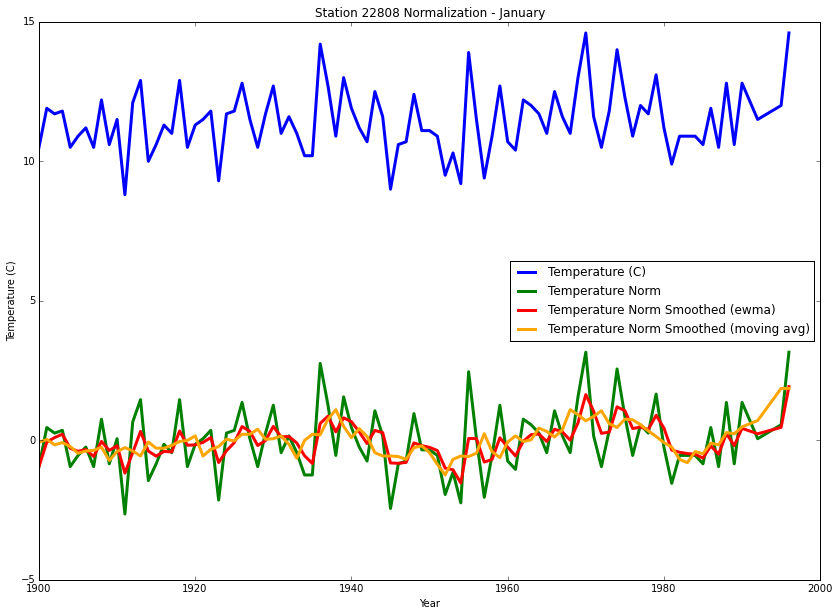

In [44]:
plt.figure(figsize=(14,10))
plt.plot(station_22808.Year,station_22808['Temperature (C)'] , color='blue',linewidth=3, label='Temperature (C)')
plt.plot(station_22808.Year,station_22808['Temperature Norm'] , color='green',linewidth=3, label='Temperature Norm')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (ewma)'] , color='red',linewidth=3, label='Temperature Norm Smoothed (ewma)')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (moving avg)'] , color='orange',linewidth=3, label='Temperature Norm Smoothed (moving avg)')
plt.legend(loc=5)
plt.title('Station 22808 Normalization - January')
plt.ylabel('Temperature (C)')
plt.xlabel('Year')
plt.show()

Focusing in the normalized values

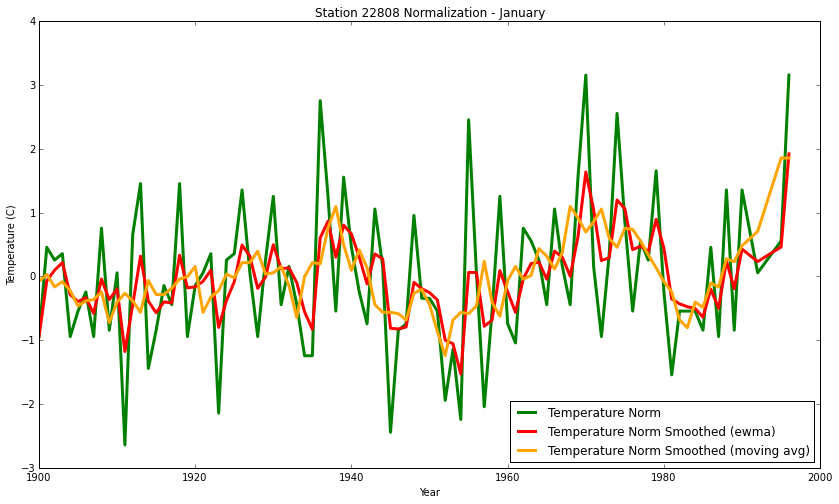

In [45]:
plt.figure(figsize=(14,8))
plt.plot(station_22808.Year,station_22808['Temperature Norm'] , color='green',linewidth=3, label='Temperature Norm')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (ewma)'] , color='red',linewidth=3, label='Temperature Norm Smoothed (ewma)')
plt.plot(station_22808.Year,station_22808['Temperature Norm Smoothed (moving avg)'] , color='orange',linewidth=3, label='Temperature Norm Smoothed (moving avg)')
plt.legend(loc=4)
plt.title('Station 22808 Normalization - January')
plt.ylabel('Temperature (C)')
plt.xlabel('Year')
plt.show()

It is easy to see that in ewma normalization the same year value has more weight than in the moving avg. We will be able to check if moving avg can adjust a regression with less error than ewma